In [48]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

import joblib
import pandas as pd

import sys
sys.path.append("..")  # so we can import from src

# from src.model import build_autoencoder
from src.train import load_creditcard_data, prepare_datasets, scale_data

In [49]:
import torch
from torch import nn

class Autoencoder(nn.Module):
    """
    Simple fully-connected autoencoder for tabular data.
    """
    def __init__(self, input_dim: int, latent_dim: int = 16):
        super().__init__()

        # Encoder: input -> latent
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )

        # Decoder: latent -> input
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon

def build_autoencoder(input_dim: int, latent_dim: int = 16) -> Autoencoder:
    return Autoencoder(input_dim=input_dim, latent_dim=latent_dim)


In [52]:
import pandas as pd
import numpy as np
from pathlib import Path

# Try loading directly without the function first
csv_path = Path("../data/creditcard.csv")

try:
    df = pd.read_csv(str(csv_path))
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Create X, y manually
    X = df.drop(columns=['Class']).values.astype(np.float32)
    y = df['Class'].values.astype(np.float32)
    
    print(f"Created X shape: {X.shape}, y shape: {y.shape}")
    
    # Continue with your pipeline
    (X_train_norm, _), (X_val_norm, _), (X_test, y_test) = prepare_datasets(X, y)
    scaler, X_train_scaled, X_val_scaled, X_test_scaled = scale_data(
        X_train_norm, X_val_norm, X_test
    )
    
    print("Train normal:", X_train_scaled.shape)
    print("Val normal:", X_val_scaled.shape)
    print("Test:", X_test_scaled.shape)
    
except FileNotFoundError:
    print(f"File not found at {csv_path.absolute()}")
    print("Current working directory:", Path.cwd())

DataFrame shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Created X shape: (284807, 30), y shape: (284807,)
Train normal: (255883, 30)
Val normal: (28432, 30)
Test: (57355, 30)


In [53]:
def make_dataloader(x, batch_size=512, shuffle=True):
    tensor_x = torch.from_numpy(x)
    dataset = TensorDataset(tensor_x)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

batch_size = 512
train_loader = make_dataloader(X_train_scaled, batch_size=batch_size, shuffle=True)
val_loader = make_dataloader(X_val_scaled, batch_size=batch_size, shuffle=False)

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

input_dim = X_train_scaled.shape[1]
latent_dim = 16

model = build_autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)

print("Model repr:\n", model)
print("\nModel class:", model.__class__)
print("Is nn.Module?", isinstance(model, nn.Module))

params = list(model.parameters())
print("Number of parameter tensors:", len(params))
print("Total number of parameters:", sum(p.numel() for p in params))



Using Device: cpu
Model repr:
 Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=30, bias=True)
  )
)

Model class: <class '__main__.Autoencoder'>
Is nn.Module? True
Number of parameter tensors: 12
Total number of parameters: 26542


In [56]:
criterion = nn.MSELoss(reduction="mean")
optimizer = Adam(model.parameters(), lr=1e-3)

## Training loop with logging

In [60]:
num_epochs = 30
train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in range(1, num_epochs+1):
    model.train()
    train_losses = []

    for (batch_x,) in train_loader:
        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        recon = model(batch_x)
        loss = criterion(recon, batch_x)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = float(np.mean(train_losses))

     # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for (batch_x,) in val_loader:
            batch_x = batch_x.to(device)
            recon = model(batch_x)
            loss = criterion(recon, batch_x)
            val_losses.append(loss.item())

    avg_val_loss = float(np.mean(val_losses))

    train_losses_per_epoch.append(avg_train_loss)
    val_losses_per_epoch.append(avg_val_loss)

    print(f"Epoch [{epoch}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.6f} | "
          f"Val Loss: {avg_val_loss:.6f}")

Epoch [1/30] - Train Loss: 0.071857 | Val Loss: 0.064406
Epoch [2/30] - Train Loss: 0.059264 | Val Loss: 0.058303
Epoch [3/30] - Train Loss: 0.051754 | Val Loss: 0.045831
Epoch [4/30] - Train Loss: 0.044607 | Val Loss: 0.041586
Epoch [5/30] - Train Loss: 0.040838 | Val Loss: 0.039883
Epoch [6/30] - Train Loss: 0.037590 | Val Loss: 0.037831
Epoch [7/30] - Train Loss: 0.035720 | Val Loss: 0.033863
Epoch [8/30] - Train Loss: 0.033104 | Val Loss: 0.031866
Epoch [9/30] - Train Loss: 0.031577 | Val Loss: 0.030380
Epoch [10/30] - Train Loss: 0.030787 | Val Loss: 0.028868
Epoch [11/30] - Train Loss: 0.028926 | Val Loss: 0.027053
Epoch [12/30] - Train Loss: 0.029208 | Val Loss: 0.026711
Epoch [13/30] - Train Loss: 0.026114 | Val Loss: 0.024820
Epoch [14/30] - Train Loss: 0.025670 | Val Loss: 0.024788
Epoch [15/30] - Train Loss: 0.024508 | Val Loss: 0.022822
Epoch [16/30] - Train Loss: 0.024340 | Val Loss: 0.022974
Epoch [17/30] - Train Loss: 0.023323 | Val Loss: 0.026617
Epoch [18/30] - Train L

## Plot training vs validation loss

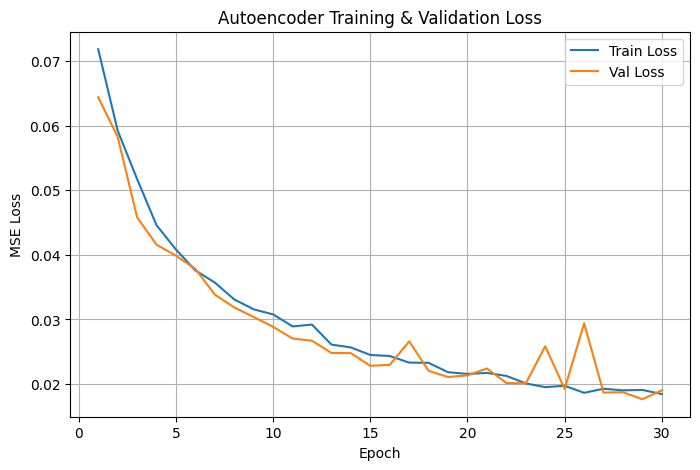

In [61]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_per_epoch, label="Train Loss")
plt.plot(epochs, val_losses_per_epoch, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

# Save scaler
scaler_path = models_dir / "scaler.pkl"
joblib.dump(scaler, scaler_path)
print("Saved scaler to:", scaler_path)

# Save model
model_path = models_dir / "autoencoder_best.pth"
torch.save(model.state_dict(), model_path)
print("Saved model to:", model_path)

# Save test arrays
np.save(models_dir / "X_test_scaled.npy", X_test_scaled)
np.save(models_dir / "y_test.npy", y_test)
print("Saved X_test_scaled.npy and y_test.npy")


Saved scaler to: ..\models\scaler.pkl
Saved model to: ..\models\autoencoder_best.pth
Saved X_test_scaled.npy and y_test.npy
